**Author**: Andy Tzanidakis \
**Last updated**: May 15, 2024

## Overview

In this notebook we will learn how to use the outputs from LSDB catalogs and use `ensemble` from TAPE to compute time-series features.

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
import dask
from dask.distributed import Client

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata
import tape
from tape import Ensemble, ColumnMapper

# Astropy
from astropy.timeseries import LombScargle

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')
print(f'Version of TAPE is {tape.__version__}')

Version of lsdb is 0.2.4.dev11+gbe3e2fd
Version of TAPE is 0.3.5


## Initialize hipscat catalogs

In [2]:
%%time

# URL path to hipscat surveys
catalogs_dir = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf/ztf_dr14/" # object
ztf_source_path = f"{catalogs_dir}/ztf/ztf_zource/" # source

# Load Gaia object table
gaia = lsdb.read_hipscat(gaia_path, columns=['ra', 'dec', 'parallax'])
# Load ZTF object table
ztf = lsdb.read_hipscat(ztf_object_path, columns=['ra', 'dec', 'ps1_objid'])
# Load ZTF DR14 zources
ztf_sources = lsdb.read_hipscat(ztf_source_path, columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'])

CPU times: user 2.77 s, sys: 311 ms, total: 3.08 s
Wall time: 3.94 s


## Cone Search 

In [3]:
%%time

# Cone search of 5000 arcseconds radius, around a given position
ra, dec = 132.8460000, +11.8140000
radius_arcsec = 5_000  # in arcsec

crossmatch_radius_arcsec = 3  # in arcsec

_sample = ztf.cone_search(ra, dec, radius_arcsec).crossmatch(
    gaia, radius_arcsec=crossmatch_radius_arcsec
).compute()

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


CPU times: user 3.94 s, sys: 2 s, total: 5.94 s
Wall time: 2.45 s


In [4]:
_sample

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec
_hipscat_index,,,,,,,
1195635224533270528,133.233700,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933
1195635242824630272,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202
1195635245353795584,133.225766,10.486782,120581332257664629,133.225770,10.486761,0.777203,0.077445
1195681424221405184,133.356580,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692
1195681461315829760,133.379456,10.529030,120631333794875301,133.379471,10.529019,<NA>,0.067189
...,...,...,...,...,...,...,...
1216416656180379648,132.783272,13.193240,123831327832352378,132.783269,13.193228,<NA>,0.044713
1216420518253559808,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951
1216420530047942656,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055


In [5]:
print (f"Number of objects in crossmatch: {len(_sample)}")

Number of objects in crossmatch: 36717


In [6]:
%%time

# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(_sample, ra_column="ra_ztf_dr14", dec_column="dec_ztf_dr14", lowest_order=5)

CPU times: user 50.6 s, sys: 74.2 ms, total: 50.7 s
Wall time: 50.8 s


In [7]:
_sample_hips

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,Norder,Dir,Npix
npartitions=6,,,,,,,,,,
1194579801160024064,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
1196831600973709312,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
1215971899390033920,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...


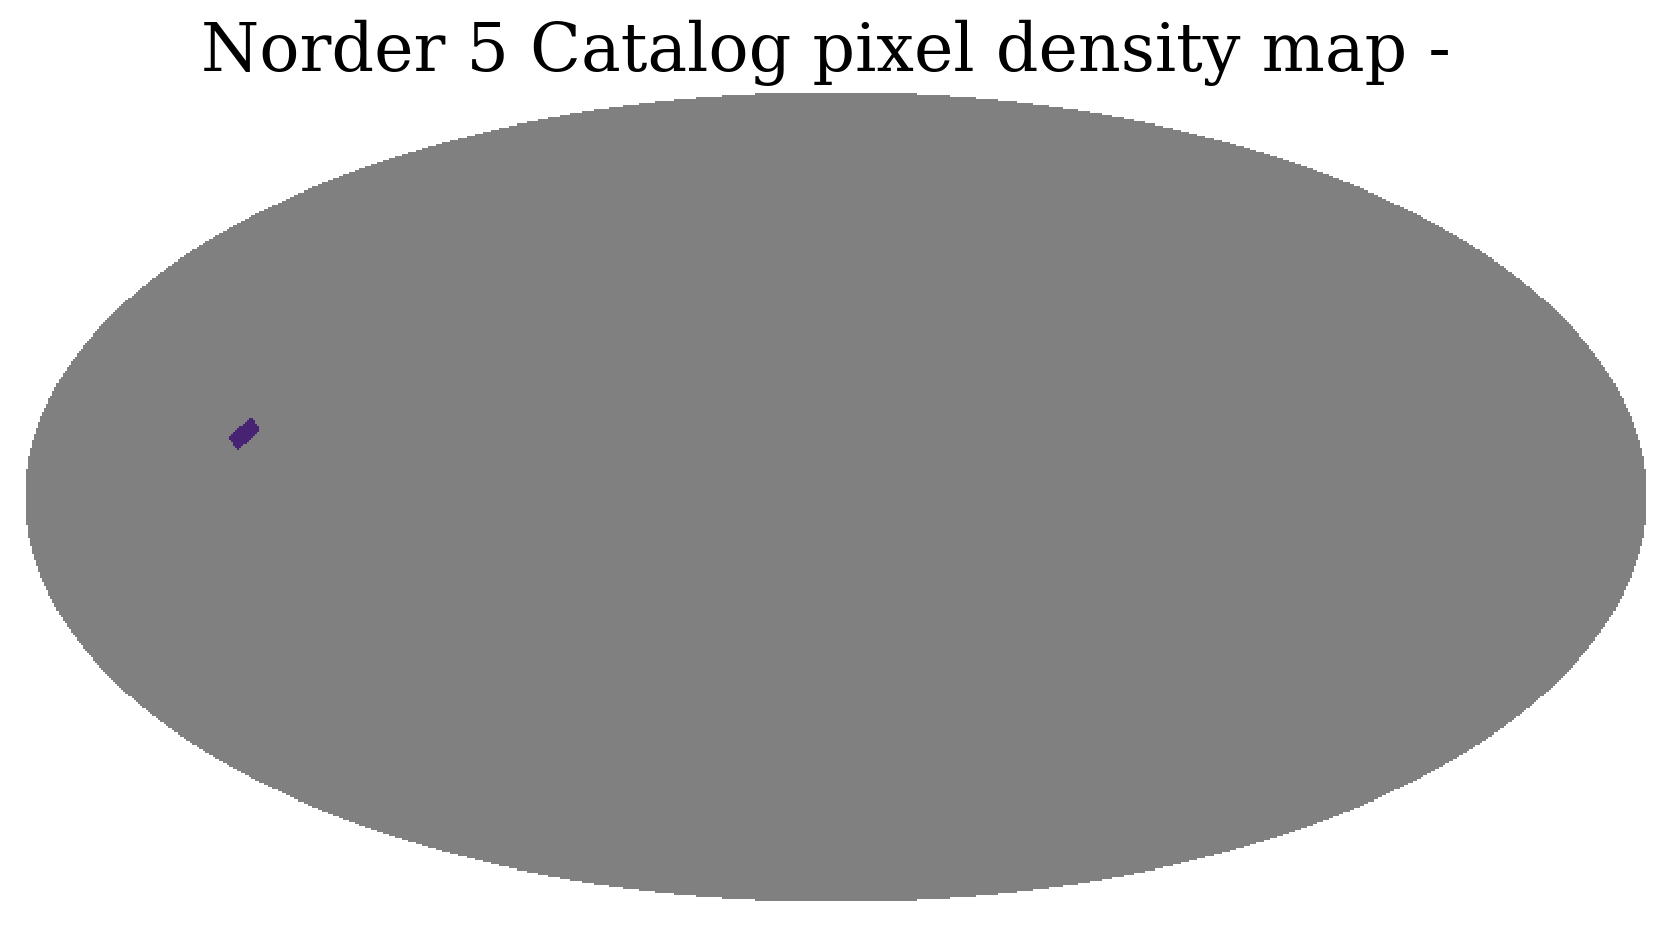

In [8]:
# We selected a very small region of the sky (5000 arcsec) and, as a result, 
# our objects are contained in a handful of pixels at order 5
plot_pixels(_sample_hips.hc_structure)

### Join sample hips with ZTF sources 

In [9]:
# Peform a join between the crossmatch and the ZTF sources using the PS1 object ID
ss = _sample_hips.join(ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/join_catalog_data.py:196: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [11]:
print (f"Number of available columns: {len(ss.columns)}")

Number of available columns: 18


### Initialize Dask Client

In [12]:
# Initialize dask client with 2 workers
# We initialize with 12 GiB of memory and 1 thread per worker, so that we sure we do not overload 
# the memory resources of the machine
from dask.distributed import Client
client = Client(n_workers=2, memory_limit="12GiB", threads_per_worker=1)

## Initialize TAPE `ensemble`

The TAPE `ensemble` specializes performing time-domain work on object/source data. Like `LSDB`, it's built on top of Dask. In the following cell, we initialize an `Ensemble` object and pass it the dask client to run computations on.

In [104]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble - pass the dask client to the ensemble
ens = Ensemble(client=client)

ens.client # display client information

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33019,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: 59 minutes ago,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:36944,Total threads: 1
Dashboard: http://127.0.0.1:34308/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:42122,


Loading data into TAPE has two steps, the first is to establish a `ColumnMapper` which maps columns from the table to known timeseries quantities. These columns are used implicitly in some TAPE functionality. The second step is to call a loader function to get data into LSDB. In this case, we can load directly from LSDB catalogs, using the `from_lsdb` function. We provide a source catalog and an object catalog as well as the `ColumnMapper`.

In [105]:
# ColumnMapper establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
    id_col='_hipscat_index',
    time_col='mjd_ztf_zource',
    flux_col='mag_ztf_zource',
    err_col='magerr_ztf_zource',
    band_col='band_ztf_zource',
)

# Create Ensemble from LSDB catalogs
ens.from_lsdb(
    source_catalog=ss,
    object_catalog=_sample_hips,
    column_mapper=colmap,
    sync_tables=False,
    sorted=True,
    sort=True,
)

Within the Ensemble, we're able to access our Object and Source tables.

In [60]:
ens.object.head(5)

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,
1195635224533270528,133.233700,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933,5,0,1061
1195635242824630272,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202,5,0,1061
1195635245353795584,133.225766,10.486782,120581332257664629,133.225770,10.486761,0.777203,0.077445,5,0,1061
1195681424221405184,133.356580,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692,5,0,1061
1195681461315829760,133.379456,10.529030,120631333794875301,133.379471,10.529019,<NA>,0.067189,5,0,1061


In [61]:
ens.source.head(5)

,ra_ztf_dr14_,dec_ztf_dr14_,ps1_objid_ztf_dr14_,ra_gaia_,dec_gaia_,parallax_gaia_,_dist_arcsec_,Norder_,Dir_,Npix_,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
_hipscat_index,,,,,,,,,,,,,,,,,,
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933,5,0,1061,133.2337,10.485653,58803.49154,20.267517,0.160889,r,120581332336983267,0
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933,5,0,1061,133.2337,10.485653,58803.48974,20.203039,0.154155,r,120581332336983267,0
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933,5,0,1061,133.2337,10.485653,58803.49064,19.950096,0.129314,r,120581332336983267,0
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933,5,0,1061,133.2337,10.485653,58803.48295,20.111149,0.144816,r,120581332336983267,0
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933,5,0,1061,133.2337,10.485653,58803.49019,20.260263,0.160125,r,120581332336983267,0


In [17]:
len(ens.source.columns)

18

## Define Custom Time Series Function

TAPE allows you to write custom analysis functions that can be passed along to each timeseries in your dataset. We'll define a custom feature calculation function.

In [116]:
def compute_optimized_periodogram_grid(x0, oversampling_factor=5, nyquist_factor=3):
    """
    Computes an optimized periodogram frequency grid for a given time series. 

    Parameters:
    ----------
    x0 (array-like): The input time axis.
    oversampling_factor (int, optional): The oversampling factor for frequency grid. Default is 5.
    nyquist_factor (int, optional): The Nyquist factor for frequency grid. Default is 3.

    Returns:
    ----------
    array: The computed optimized periodogram frequency grid.
    """

    num_points = len(x0)
    baseline = np.max(x0) - np.min(x0)

    # Calculate the frequency resolution based on oversampling factor and baseline
    frequency_resolution = 1. / baseline / oversampling_factor

    # Calculate the number of frequencies and the frequency grid
    num_frequencies = int(0.5 * oversampling_factor * nyquist_factor * num_points)
    frequencies = frequency_resolution + frequency_resolution * np.arange(num_frequencies)

    return frequencies


def calc_invNeumann(t, mag, wstd):
    """ Calculate the time-weighted inverse Von Neumann statatistic.

    Parameters:
    ----------
    t (array-like): The input time axis.
    mag (array-like): The input magnitude axis.
    wstd (float): The weighted standard deviation of the magnitude.

    Returns:
    ----------
    float: The time-weighted inverse Von Neumann stat.

    Reference:
    ----------
        [1]: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    dt = t[1:] - t[:-1]
    dm = mag[1:] - mag[:-1]

    w = (dt) ** -2  # inverse deltat weighted
    eta = np.sum(w * dm**2)
    eta /= np.sum(w) * wstd**2

    return eta**-1


def calc_NormExcessVar(mag, err, N, wmean):
    """ Calculate the normalized excess variance statistic.

    Parameters:
    ----------
    mag (array-like): The input magnitude axis.
    err (array-like): The input magnitude error axis.
    N (int): The number of data points.
    wmean (float): The weighted mean of the magnitude.

    Returns:
    ----------
    float: The normalized excess variance statistic.

    Reference:
    ----------
        [1]: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    stat = np.sum((mag - wmean) ** 2 - err**2)
    stat /= N * wmean**2
    return stat

# Column names for the custom features
cols = ['period', 'power', 'snr', 'mean', 'invNeumann', 'NormExcessVar', 'Nphot']

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=cols, dtype=float)

def calc_features(time, mag, magerr, flag, band, custom_cols=cols):
    """Custom time-series features calculator.
    
    Parameters:
    ----------
    time (array-like): The input time axis.
    mag (array-like): The input magnitude axis.
    magerr (array-like): The input magnitude error axis.
    flag (array-like): The input flag axis.
    band (array-like): The input band axis.

    Returns:
    ----------
    pd.Series: The computed custom time-series features.
    """

    # Quality flags
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)
    
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]
    
    if len(time_)>0:
        lsp = LombScargle(time_,
                          mag_,
                          magerr_,
                          fit_mean=True,
                          center_data=True,
                          nterms=1, 
                         normalization='standard')
        
        # Determine optimal frequency grid given data...
        f_grid = compute_optimized_periodogram_grid(time,
                                                    oversampling_factor=0.3, nyquist_factor=100)
        power = lsp.power(f_grid)
        period = 1/f_grid
        snr = (max(power)-np.mean(power))/np.std(power) # snr of periodogram 

        # Other featues to compute 
        Neu = calc_invNeumann(time_, mag_, np.nanstd(mag_))
        ExcVar = calc_NormExcessVar(mag_, magerr_, len(mag_), np.nanstd(mag_))
        Nphot = len(time_)

        return pd.Series([period[np.argmax(power)], power[np.argmax(power)], snr, np.nanmean(mag_), Neu, ExcVar, Nphot],
                            index=custom_cols)  
    else:
        return pd.Series([0, 0, 0, 0, 0, 0, 0], index=custom_cols)  

Our function will operate on r-band data. We can use TAPE's filtering utilities to make sure that only lightcurves that have at least a few observations in r-band.

In [107]:
# Filter to r-band
ens = ens.source.query("band_ztf_zource == 'r'").update_ensemble() # update returns an ensemble object

# Filter on lightcurves that have at least 10 observations in r-band
ens = ens.prune(10)

In [108]:
#ens.source['_hipscat_index']

In [92]:
ens.source._meta

,ra_ztf_dr14_,dec_ztf_dr14_,ps1_objid_ztf_dr14_,ra_gaia_,dec_gaia_,parallax_gaia_,_dist_arcsec_,Norder_,Dir_,Npix_,ra_ztf_zource,dec_ztf_zource,mjd_ztf_zource,mag_ztf_zource,magerr_ztf_zource,band_ztf_zource,ps1_objid_ztf_zource,catflags_ztf_zource
_hipscat_index,,,,,,,,,,,,,,,,,,


With our filtered data ready, we can use `batch` to apply the function to each lightcurve.

In [117]:
# Apply the feature calculator to each lightcurve
res2 = ens.batch(
    calc_features, 
    "mjd_ztf_zource", 
    "mag_ztf_zource", 
    "magerr_ztf_zource", 
    "catflags_ztf_zource", 
    "band_ztf_zource",
    meta=my_meta
)

Using generated label, result_3, for a batch result.


In [118]:
%%time

# Compute the result (bring it into memory)
table = res2.compute()

/tmp/ipykernel_53948/645980433.py:49: RuntimeWarning: divide by zero encountered in power
/tmp/ipykernel_53948/645980433.py:50: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_53948/645980433.py:49: RuntimeWarning: divide by zero encountered in power
/tmp/ipykernel_53948/645980433.py:50: RuntimeWarning: invalid value encountered in multiply


CPU times: user 8.75 s, sys: 3.61 s, total: 12.4 s
Wall time: 3min 24s


In [119]:
# We have the results!
table

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
_hipscat_index,,,,,,,
1195635224533270528,0.964378,0.103166,6.912092,20.102354,0.355314,15500.346712,433.0
1195635242824630272,0.488478,0.037421,7.092406,19.525126,0.494461,38152.319545,554.0
1195635245353795584,0.498667,0.049028,12.946716,17.779547,0.507209,320777.617250,617.0
1195681424221405184,0.161282,0.033920,7.621750,17.070436,0.718703,539884.092086,619.0
1195681461315829760,0.964705,0.290928,4.212915,21.006584,0.946503,7447.698083,117.0
...,...,...,...,...,...,...,...
1216416656180379648,0.466748,0.310491,4.787764,20.987270,2.272826,4936.934409,123.0
1216420518253559808,0.436900,0.248063,4.802904,20.807816,2.141703,7106.396475,192.0
1216420530047942656,0.054961,0.029600,5.820039,18.014742,0.504425,251552.368146,662.0


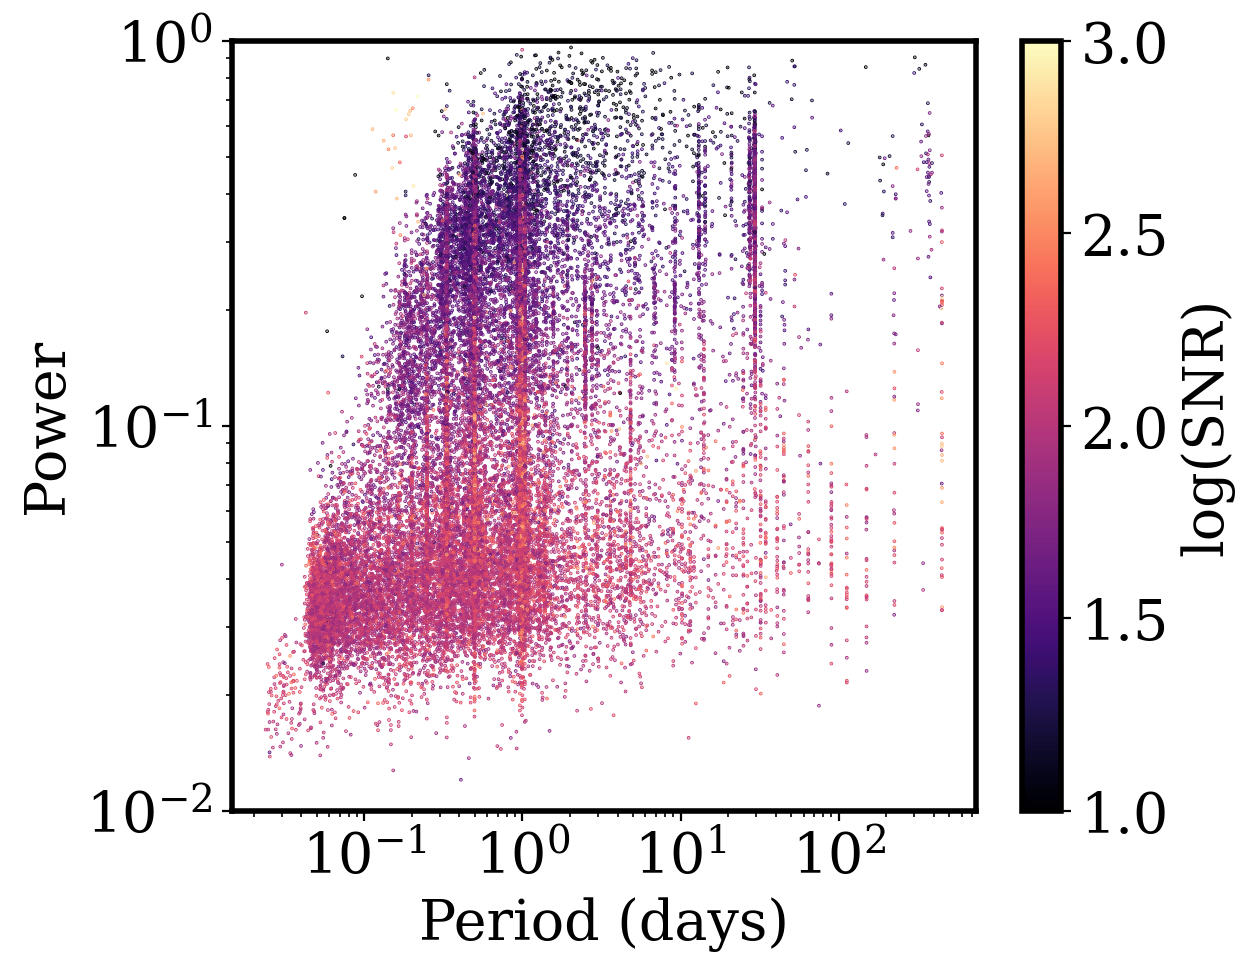

In [135]:
plt.figure(figsize=(6,5))
plt.scatter(table['period'], table['power'], s=0.1, c=np.log(table['snr']), cmap='magma', 
            vmin=1, vmax=3)
plt.colorbar(label='log(SNR)')
plt.ylim(1e-2, 1e0)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.minorticks_on()

In [209]:
# Select good SNR candidatete
table[table['snr']>20].head(30)

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
_hipscat_index,,,,,,,
1197097443984932864,0.996467,0.121413,27.713650,19.521130,0.780075,22273.011834,996.0
1197099223825252352,1.000666,0.114267,25.854882,17.913473,0.534294,152459.560039,1132.0
1197217068819152896,0.997308,12.706888,26.816483,21.342863,7.784421,5551.791061,50.0
1197242603251171328,0.998447,0.435875,57.023293,17.830879,3.072329,63327.182194,614.0
1197268156255567872,0.996452,0.228829,24.498031,18.746742,1.031202,69025.924512,599.0
1197285639016415232,0.499223,0.225049,29.332239,16.974457,1.810229,251459.947066,617.0
1197302981905612800,0.499223,0.400408,23.604132,16.473553,5.222041,79209.741173,616.0
1197362781934845952,0.996452,0.263824,20.493805,20.067131,0.881206,10263.268984,418.0
1197373173872459776,0.996238,0.247107,23.208996,17.563456,1.599916,208627.889554,617.0


## Plot Lightcurve

In [210]:
# Select a lightcurve with high SNR
lc_id = 1209433013427896320 # hips index
lc_data = ens.to_timeseries(lc_id).data
r_filter = lc_data.band_ztf_zource=='r'

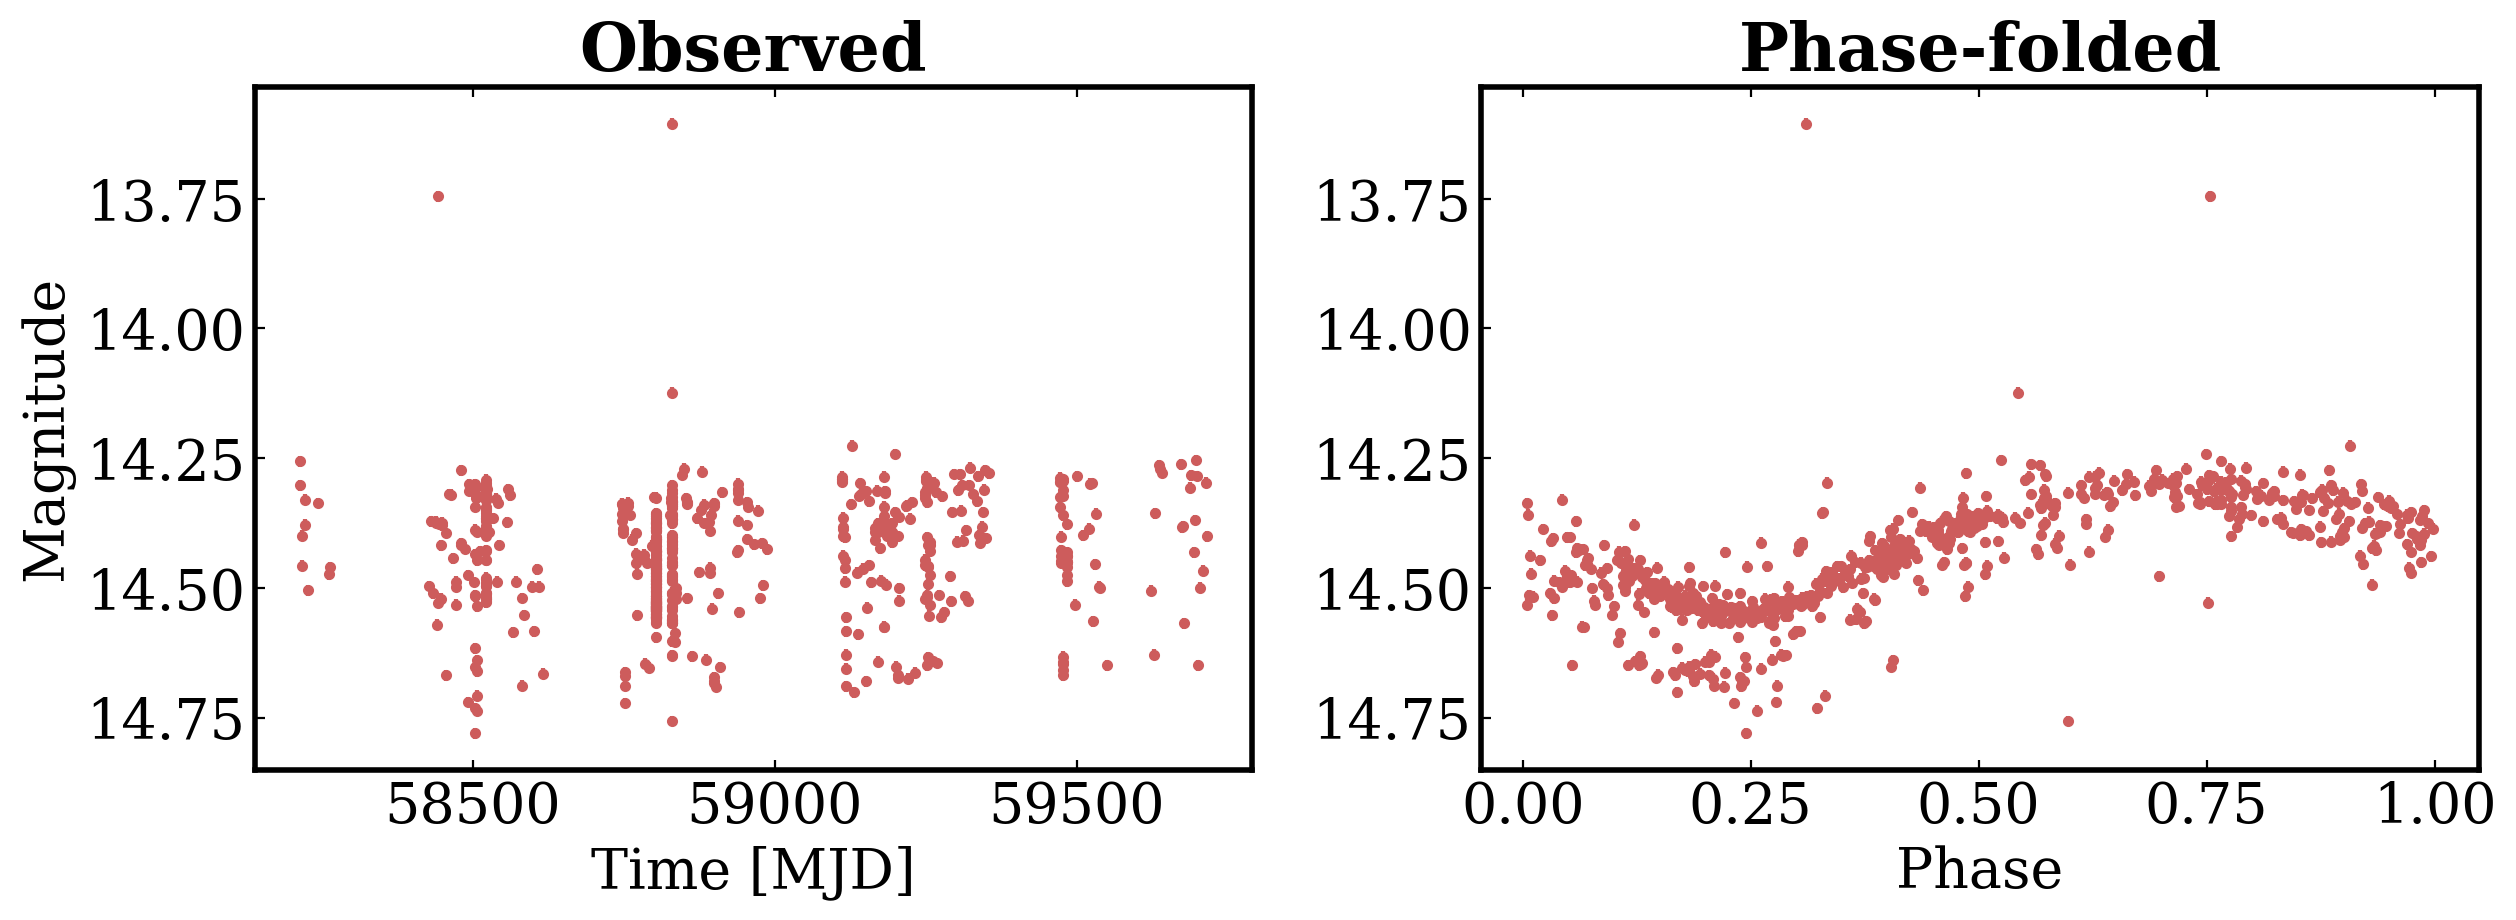

In [211]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].errorbar(
    lc_data.mjd_ztf_zource[r_filter], 
    lc_data.mag_ztf_zource[r_filter],
    yerr=lc_data.magerr_ztf_zource[r_filter], 
    fmt='.', 
    color='indianred'
)

ax[1].errorbar((lc_data.mjd_ztf_zource[r_filter].to_numpy()%0.217326)/0.217326, lc_data.mag_ztf_zource[r_filter],
                yerr=lc_data.magerr_ztf_zource[r_filter], fmt='.', color='indianred')
ax[1].set_xlabel('Phase')
ax[0].set_xlabel('Time [MJD]')
ax[1].tick_params(axis='x', which='both', bottom=True, top=True, direction='in')
ax[0].tick_params(axis='x', which='both', bottom=True, top=True, direction='in')
ax[1].tick_params(axis='y', which='both', bottom=True, top=True, direction='in')
ax[0].tick_params(axis='y', which='both', bottom=True, top=True, direction='in')
ax[0].set_ylabel('Magnitude')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Observed", weight='bold')
ax[1].set_title("Phase-folded", weight='bold')

plt.tight_layout()

In [26]:
# client.shutdown()